# Pretrained Word2Vec

In [1]:
# !pip install torchtext==0.4.0

In [2]:
# !pip install spacy

In [3]:
# !python -m spacy download en_core_web_sm

In [4]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)
LABEL = data.LabelField(dtype = torch.float)

In [5]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [7]:
print(vars(train_data.examples[0]))

{'text': ['City', 'Hall', 'takes', 'on', 'the', 'politics', 'of', 'a', 'city', 'rather', 'than', 'country', ',', 'state', 'or', 'any', 'sort', 'of', 'major', 'political', 'table', '.', 'Granted', 'it', 'shines', 'on', 'New', 'York', 'City', 'which', 'is', 'a', 'huge', 'political', 'arena', ',', 'especially', 'nowadays', ',', 'but', 'it', 'still', 'goes', 'for', 'a', 'smaller', 'scale', 'and', 'puts', 'the', 'microscope', 'on', 'a', 'few', 'key', 'players', 'in', 'a', 'city', 'wide', 'scandal', 'stumbled', 'on', 'by', 'the', 'mayor', "'s", 'right', 'hand', '.', 'Director', 'Harold', 'Becker', 'is', 'a', 'director', 'very', 'familiar', 'with', 'elements', 'of', 'the', 'thriller', 'having', 'done', 'Mercury', 'Rising', ',', 'Malice', ',', 'and', 'Domestic', 'Disturbance', 'and', 'I', 'think', 'in', 'many', 'ways', 'he', 'incorporates', 'so', 'many', 'of', 'the', 'formulaic', 'thriller', 'genre', 'that', 'its', 'almost', 'to', 'a', 'fault', '.', 'I', 'mean', 'City', 'Hall', 'is', 'meant', 

In [8]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [10]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [11]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [12]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202760), (',', 192521), ('.', 166679), ('a', 109809), ('and', 109781), ('of', 101004), ('to', 94003), ('is', 76598), ('in', 61213), ('I', 54076), ('it', 53898), ('that', 49499), ('"', 43939), ("'s", 43286), ('this', 42592), ('-', 37105), ('/><br', 35955), ('was', 35363), ('as', 30388), ('with', 30239)]


In [13]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [14]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [15]:
TEXT.__dict__

{'sequential': True,
 'use_vocab': True,
 'init_token': None,
 'eos_token': None,
 'unk_token': '<unk>',
 'fix_length': None,
 'dtype': torch.int64,
 'preprocessing': None,
 'postprocessing': None,
 'lower': False,
 'tokenizer_args': ('spacy', 'en_core_web_sm'),
 'tokenize': functools.partial(<function _spacy_tokenize at 0x7fe292925f80>, spacy=<spacy.lang.en.English object at 0x7fe28323cd90>),
 'include_lengths': True,
 'batch_first': False,
 'pad_token': '<pad>',
 'pad_first': True,
 'truncate_first': False,
 'stop_words': None,
 'is_target': False,
 'vocab': <torchtext.vocab.Vocab at 0x7fe23ee43990>}

In [16]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

In [17]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        #text = [sent len, batch size]

        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]

        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

In [18]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,643,705 trainable parameters


## Train the Model

In [33]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
criterion = nn.BCEWithLogitsLoss()

In [22]:
model = model.to(device)
criterion = criterion.to(device)

In [23]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [24]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
# N_EPOCHS = 50

# best_valid_loss = float('inf')

# for epoch in range(N_EPOCHS):

#     start_time = time.time()

#     train_loss, train_acc = train(model, train_iterator, optimizer_adam, criterion)
#     valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut1-model.pt')

#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## Task 2 - SGD vs Adam vs Adagrad

Optimizer: SGD
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.697 | Train Acc: 50.79%
	 Val. Loss: 0.694 |  Val. Acc: 51.24%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.693 | Train Acc: 52.10%
	 Val. Loss: 0.693 |  Val. Acc: 52.00%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.691 | Train Acc: 52.20%
	 Val. Loss: 0.691 |  Val. Acc: 52.28%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 52.80%
	 Val. Loss: 0.690 |  Val. Acc: 52.76%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.688 | Train Acc: 53.32%
	 Val. Loss: 0.689 |  Val. Acc: 52.98%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.687 | Train Acc: 53.95%
	 Val. Loss: 0.689 |  Val. Acc: 53.23%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 54.03%
	 Val. Loss: 0.687 |  Val. Acc: 53.81%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.685 | Train Acc: 54.74%
	 Val. Loss: 0.686 |  Val. Acc: 53.65%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.684 | Train Acc: 54.96%
	 Val. Loss: 0.685 |  Val. Acc: 54.41%
Epoch: 10 | E

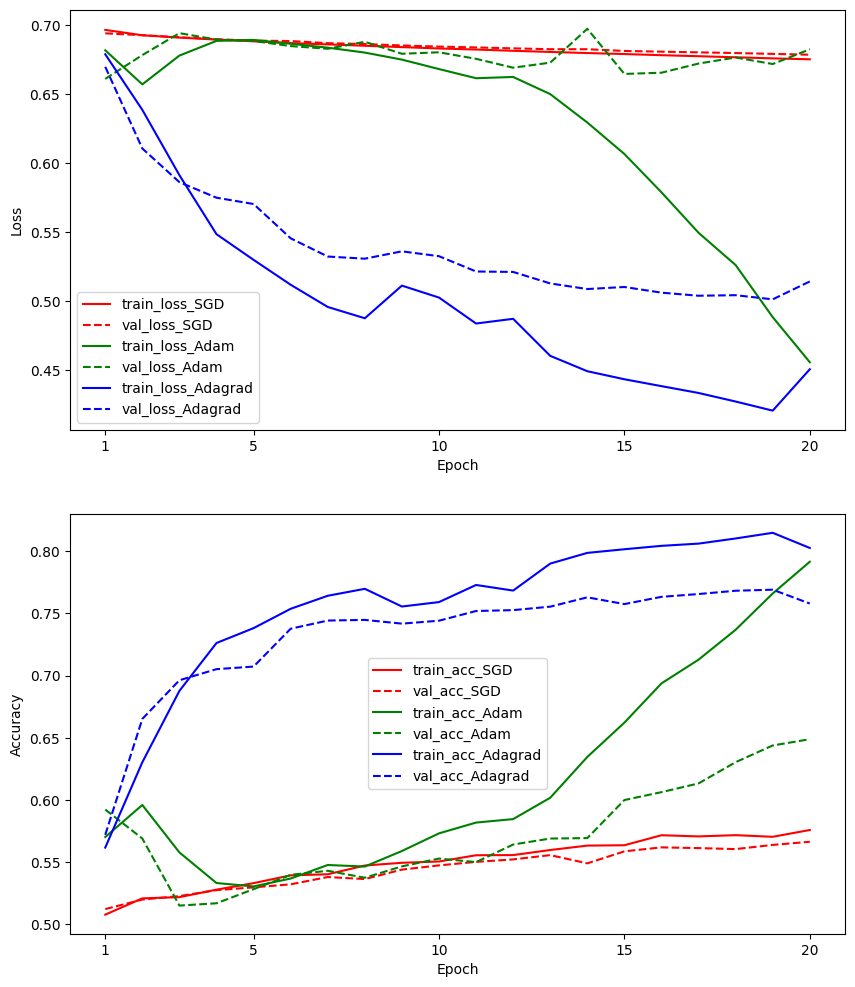

In [30]:
import matplotlib.pyplot as plt
N_EPOCHS = 20
colors_train = ['r-', 'g-', 'b-']
colors_val = ['r--', 'g--', 'b--']
plot_labels = ['SGD', 'Adam', 'Adagrad']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
ax1.set_xticks([0,4,9,14,19], labels=[1,5,10,15,20])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xticks([0,4,9,14,19], labels=[1,5,10,15,20])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

for i in range(3):

    model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    model = model.to(device)

    if i==0:
        optimizer = optim.SGD(model.parameters(), lr=1e-3)
        print('Optimizer: SGD')
    elif i==1:
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        print('Optimizer: Adam')
    else:
        optimizer = optim.Adagrad(model.parameters(), lr=1e-3)
        print('Optimizer: Adagrad')

    stat_train_loss = []
    stat_train_acc = []
    stat_val_loss = []
    stat_val_acc = []
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'model.pt')
        
        stat_train_loss.append(train_loss)
        stat_train_acc.append(train_acc)
        stat_val_loss.append(valid_loss)
        stat_val_acc.append(valid_acc)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    ax1.plot(stat_train_loss, colors_train[i], label='train_loss_'+plot_labels[i])
    ax1.plot(stat_val_loss, colors_val[i], label='val_loss_'+plot_labels[i])
    ax2.plot(stat_train_acc, colors_train[i], label='train_acc_'+plot_labels[i])
    ax2.plot(stat_val_acc, colors_val[i], label='val_acc_'+plot_labels[i])

    print(f'Training completed')
    print(f'Test:')

    model.load_state_dict(torch.load('model.pt'))
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print('------------------')

ax1.legend()
ax2.legend()

## Task 3 - Epochs

N_epoch 5 training completed
Training duration: 17.52s
N_epoch 5 test:
Test Loss: 0.608 | Test Acc: 68.11%
N_epoch 10 training completed
Training duration: 35.02s
N_epoch 10 test:
Test Loss: 0.641 | Test Acc: 67.28%
N_epoch 20 training completed
Training duration: 69.68s
N_epoch 20 test:
Test Loss: 0.642 | Test Acc: 66.72%
N_epoch 50 training completed
Training duration: 175.99s
N_epoch 50 test:
Test Loss: 0.537 | Test Acc: 74.71%


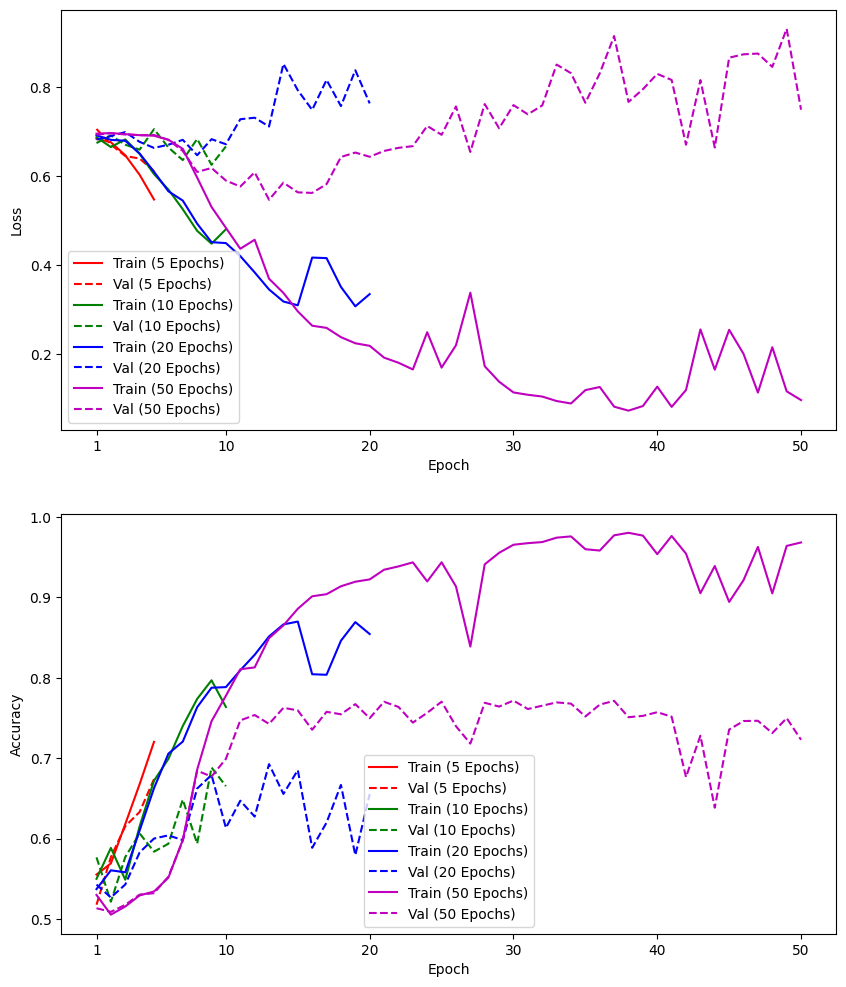

In [32]:
colors_train = ['r-', 'g-', 'b-', 'm-']
colors_val = ['r--', 'g--', 'b--', 'm--']

N_EPOCHS = [5, 10, 20, 50]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

for i in range(4):
    model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
    model = model.to(device)
    optimizer_Adam = optim.Adam(model.parameters(), lr=1e-3)

    train_loss_Adam = []
    train_acc_Adam = []
    val_loss_Adam = []
    val_acc_Adam = []
    best_valid_loss = float('inf')

    start_time = time.time()

    for epoch in range(N_EPOCHS[i]):

        train_loss, train_acc = train(model, train_iterator, optimizer_Adam, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
      
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'model_Adam.pt')
        
        train_loss_Adam.append(train_loss)
        train_acc_Adam.append(train_acc)
        val_loss_Adam.append(valid_loss)
        val_acc_Adam.append(valid_acc)

    end_time = time.time()
    epoch_secs =  end_time - start_time

    ax1.plot(train_loss_Adam, colors_train[i])
    ax1.plot(val_loss_Adam, colors_val[i])
    ax2.plot(train_acc_Adam, colors_train[i])
    ax2.plot(val_acc_Adam, colors_val[i])

    print(f'N_epoch {N_EPOCHS[i]} training completed')
    print(f'Training duration: {epoch_secs:.2f}s')
    print(f'N_epoch {N_EPOCHS[i]} test:')

    model.load_state_dict(torch.load('model_Adam.pt'))
    test_loss_Adam, test_acc_Adam = evaluate(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss_Adam:.3f} | Test Acc: {test_acc_Adam*100:.2f}%')

ax1.legend(['Train (5 Epochs)', 'Val (5 Epochs)', 
            'Train (10 Epochs)', 'Val (10 Epochs)',
            'Train (20 Epochs)', 'Val (20 Epochs)',
            'Train (50 Epochs)', 'Val (50 Epochs)'])

ax2.legend(['Train (5 Epochs)', 'Val (5 Epochs)', 
            'Train (10 Epochs)', 'Val (10 Epochs)',
            'Train (20 Epochs)', 'Val (20 Epochs)',
            'Train (50 Epochs)', 'Val (50 Epochs)'])

## Task 4 - Word2Vec

In [34]:
from gensim.models import KeyedVectors
import torch.nn as nn
import numpy as np

In [36]:
pretrained_word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

new_weights = np.zeros((len(TEXT.vocab), pretrained_word2vec.vectors.shape[1]))

for i in range(len(TEXT.vocab)):
  word = TEXT.vocab.itos[i]
  if word in pretrained_word2vec:
    new_weights[i,:] = pretrained_word2vec[word]

new_weights = torch.FloatTensor(new_weights)
print('Done')
print(f'Shape of new_weights: {new_weights.shape}')

Done
Shape of new_weights: torch.Size([25002, 300])


In [37]:
class RNN_pretrained(nn.Module):
    def __init__(self, weights, hidden_dim, output_dim):
        
        super().__init__()
        
        self.input_dim = weights.shape[0]
        self.embedding_dim = weights.shape[1]
        
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        
        self.rnn = nn.RNN(self.embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):

        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        
        return self.fc(hidden.squeeze(0)) # [batch_size, 1]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.633 | Train Acc: 63.38%
	 Val. Loss: 0.622 |  Val. Acc: 64.33%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.481 | Train Acc: 77.35%
	 Val. Loss: 0.554 |  Val. Acc: 77.08%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.447 | Train Acc: 78.27%
	 Val. Loss: 0.564 |  Val. Acc: 74.11%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.315 | Train Acc: 87.01%
	 Val. Loss: 0.583 |  Val. Acc: 75.53%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.287 | Train Acc: 88.05%
	 Val. Loss: 0.598 |  Val. Acc: 77.21%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.306 | Train Acc: 85.97%
	 Val. Loss: 0.808 |  Val. Acc: 60.55%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.261 | Train Acc: 89.08%
	 Val. Loss: 0.649 |  Val. Acc: 76.02%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.150 | Train Acc: 94.50%
	 Val. Loss: 0.833 |  Val. Acc: 71.65%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.168 | Train Acc: 93.49%
	 Val. Loss: 0.829 |  Val. Acc: 70.73%
Epoch: 10 | Epoch Time: 0m 3

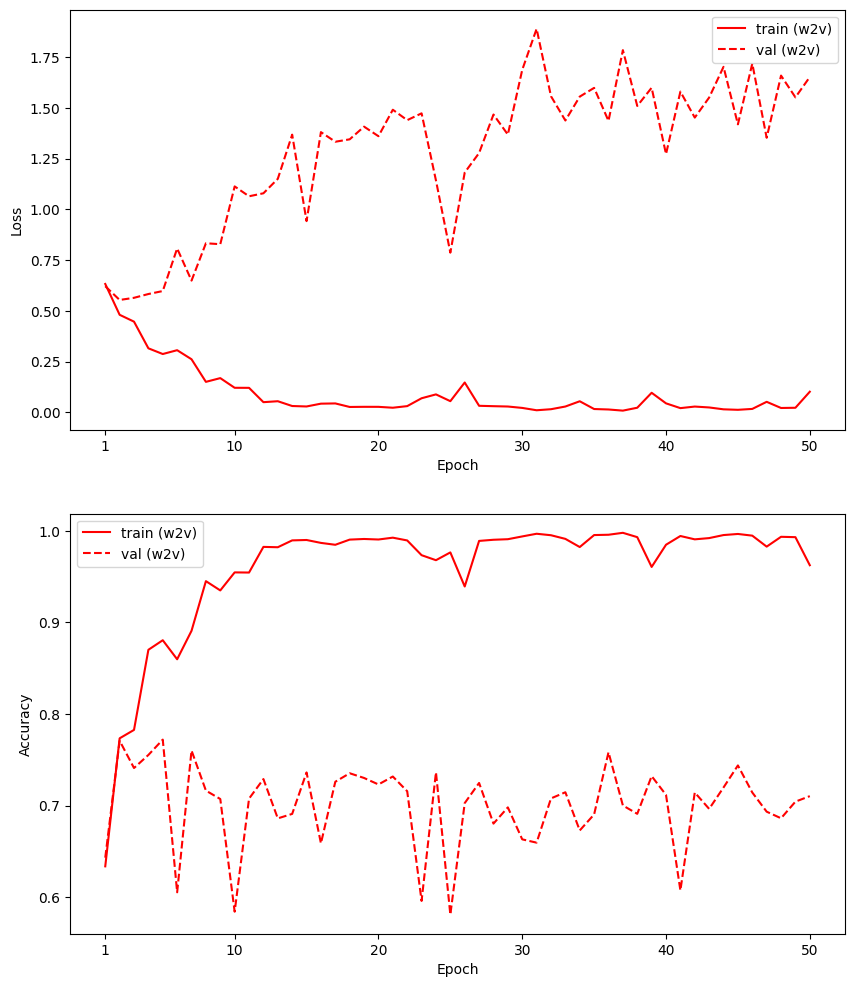

In [39]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model_pretrained = RNN_pretrained(new_weights, HIDDEN_DIM, OUTPUT_DIM)
optimizer_Adam = optim.Adam(model_pretrained.parameters(), lr=1e-3)
model_pretrained = model_pretrained.to(device)

N_EPOCHS = 50

# Adam optimizer
train_loss_w2v = []
train_acc_w2v = []
val_loss_w2v = []
val_acc_w2v = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_pretrained, train_iterator, optimizer_Adam, criterion)
    valid_loss, valid_acc = evaluate(model_pretrained, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_pretrained.state_dict(), 'model_w2v.pt')
    
    train_loss_w2v.append(train_loss)
    train_acc_w2v.append(train_acc)
    val_loss_w2v.append(valid_loss)
    val_acc_w2v.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))
ax1.plot(train_loss_w2v, 'r-', label='train (w2v)')
ax1.plot(val_loss_w2v, 'r--', label='val (w2v)')
ax2.plot(train_acc_w2v, 'r-', label='train (w2v)')
ax2.plot(val_acc_w2v, 'r--', label='val (w2v)')

ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()


# 
model_pretrained.load_state_dict(torch.load('model_w2v.pt'))

test_loss_w2v, test_acc_w2v = evaluate(model_pretrained, test_iterator, criterion)

print(f'Test Loss: {test_loss_w2v:.3f} | Test Acc: {test_acc_w2v*100:.2f}%')

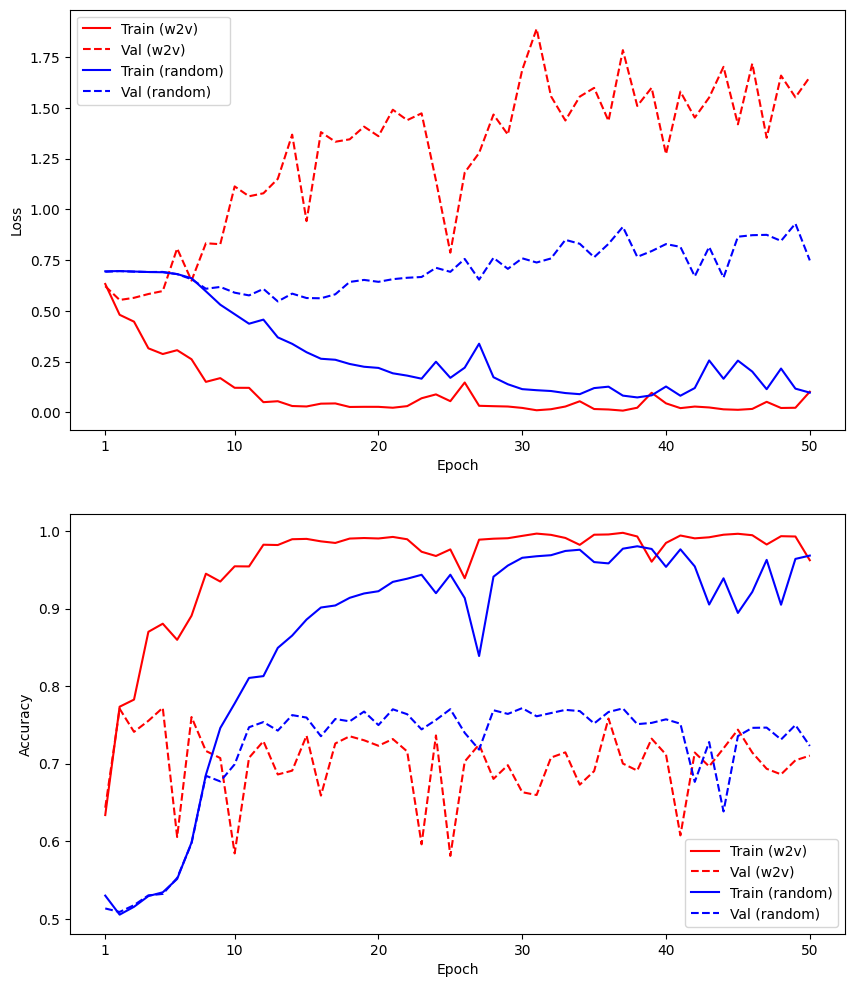

In [40]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))

ax1.plot(train_loss_w2v, 'r-', label='Train (w2v)')
ax1.plot(val_loss_w2v, 'r--', label='Val (w2v)')
ax1.plot(train_loss_Adam, 'b-', label='Train (random)')
ax1.plot(val_loss_Adam, 'b--', label='Val (random)')

ax2.plot(train_acc_w2v, 'r-', label='Train (w2v)')
ax2.plot(val_acc_w2v, 'r--', label='Val (w2v)')
ax2.plot(train_acc_Adam, 'b-', label='Train (random)')
ax2.plot(val_acc_Adam, 'b--', label='Val (random)')

ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()